In [2]:
##ma14_small <- readRDS("ma_panel_2014.rds")[,
##  c("year", "county", "contractid", "planid", "plan_type", "partd", "snp")
##]
##saveRDS(ma14_small, "ma14_small.rds")
##rm(ma14_small)
##gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,957396,51.2,1782404,95.2,1430253,76.4
Vcells,1683819,12.9,470929356,3593.0,575234890,4388.7


In [6]:
library(tidyverse)
library(haven)
library(MatchIt)

# Helper function to load one year's MA panel and keep relevant columns
load_ma_year <- function(year) {
  message("Loading ", year)
  readRDS(paste0("ma_panel_", year, ".rds")) %>%
    select(
      year,
      county,
      fips,
      contractid,
      planid,
      plan_type,
      partd,
      snp,
    )
}

# Load each year
ma14 <- load_ma_year(2014)
ma15 <- load_ma_year(2015)
ma16 <- load_ma_year(2016)
ma17 <- load_ma_year(2017)
ma18 <- load_ma_year(2018)
ma19 <- load_ma_year(2019)

# Combine all years
ma_all <- bind_rows(ma14, ma15, ma16, ma17, ma18, ma19)

# Quick check
count(ma_all, year)

Loading 2014

Loading 2015

Loading 2016

Loading 2017

Loading 2018

Loading 2019



year,n
<int>,<int>
2014,28652609
2015,26996120
2016,24167634
2017,25278655
2018,27710394
2019,32609878


In [ ]:
##Q1
library(tidyverse)
# Function to load and clean one year's data
clean_ma_year <- function(file) {
  message("Loading ", file)
  readRDS(file) %>%
    # keep only necessary columns
    select(year, fips, planid, snp, partd) %>%
    # filter out unwanted plans
    filter(
      snp == "No",            # remove SNPs
      partd == "Yes",          # must offer Part C benefits
      !(planid >= 800 & planid < 900) # remove 800-series plans
    )
}

# List of yearly files
files <- paste0("ma_panel_", 2014:2019, ".rds")

# Process each year individually, store cleaned data summaries
plan_summaries <- lapply(files, function(f) {
  data_year <- clean_ma_year(f)
  
  # summarize # of plans by county
  data_year %>%
    group_by(year, fips) %>%
    summarise(n_plans = n_distinct(planid), .groups = "drop")
})

# Combine the yearly summaries (much smaller than full data)
plans_by_county <- bind_rows(plan_summaries)

# Boxplot of # of plans per county over time
ggplot(plans_by_county, aes(x = factor(year), y = n_plans)) +
  geom_boxplot() +
  labs(
    x = "Year",
    y = "Number of Plans per County",
    title = "Distribution of Medicare Advantage Plan Counts by County (2014-2019)"
  ) +
  theme_minimal()

Loading ma_panel_2014.rds



In [4]:
##Q2
library(tidyverse)
library(lubridate)
library(stringr)
library(purrr)
library(data.table)
library(readxl)

# Source helper functions from the repo
source("R_code/fn_plan_characteristics.R")
source("R_code/rating_variables.R")

# Source the build function
build_year_ma <- function(y) {
  message("Building data for year: ", y)

  source("R_code/1_plan-data.R", local = TRUE)
  fp <- final.plans

  source("R_code/2_service-area.R", local = TRUE)
  fsa <- final.service.area

  source(paste0("R_code/3_plan-characteristics-", y, ".R"), local = TRUE)
  fls <- final.landscape %>% mutate(state = str_to_lower(state))

  source("R_code/4_penetration.R", local = TRUE)
  fpen <- final.penetration

  source(paste0("R_code/5_star-ratings-", y, ".R"), local = TRUE)
  fsr <- final.star.ratings

  source(paste0("R_code/6_risk-rebates-", y, ".R"), local = TRUE)
  frr <- final.risk.rebate

  source(paste0("R_code/7_benchmarks-", y, ".R"), local = TRUE)
  fbm <- final.benchmark

  source(paste0("R_code/8_ffs-costs-", y, ".R"), local = TRUE)
  ffs <- final.ffs.costs

  # Build final MA dataset
  final.ma <- fp %>%
    inner_join(fsa %>% select(contractid, fips, year),
               by = c("contractid","fips","year")) %>%
    filter(!state %in% c("VI","PR","MP","GU","AS",""),
           snp == "No",
           (planid < 800 | planid >= 900),
           !is.na(planid), !is.na(fips)) %>%
    left_join(fsr, by = c("contractid","year")) %>%
    left_join(fpen %>% ungroup() %>% rename(state_long = state, county_long = county) %>%
                mutate(state_long = str_to_lower(state_long)),
              by = c("fips","year")) %>%
    left_join(fls, by = c("contractid","planid","state_name" = "state","county","year")) %>%
    left_join(frr %>% select(-contract_name, -plan_type), by = c("contractid","planid","year")) %>%
    left_join(fbm %>% mutate(ssa = as.numeric(ssa)), by = c("ssa","year")) %>%
    left_join(ffs %>% select(-state), by = c("ssa","year")) %>%
    mutate(
      bid = case_when(
        rebate_partc == 0 & basic_premium > 0 ~ (payment_partc + basic_premium) / riskscore_partc,
        rebate_partc > 0 | basic_premium == 0 ~ payment_partc / riskscore_partc,
        TRUE ~ NA_real_
      )
    )

  final.ma
}

# Build only 2014 and 2018 datasets for your Q2 plots
ma14_full <- build_year_ma(2014)
ma18_full <- build_year_ma(2018)

# Filter out missing bids
ma14_bids <- ma14_full %>% filter(!is.na(bid))
ma18_bids <- ma18_full %>% filter(!is.na(bid))

# Plot histograms
ggplot(ma14_bids, aes(x = bid)) +
  geom_histogram(bins = 50, fill = "steelblue", color = "white") +
  labs(title = "Distribution of Plan Bids (2014)", x = "Bid", y = "Count") +
  theme_minimal()

ggplot(ma18_bids, aes(x = bid)) +
  geom_histogram(bins = 50, fill = "darkorange", color = "white") +
  labs(title = "Distribution of Plan Bids (2018)", x = "Bid", y = "Count") +
  theme_minimal()


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'R_code/fn_plan_characteristics.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


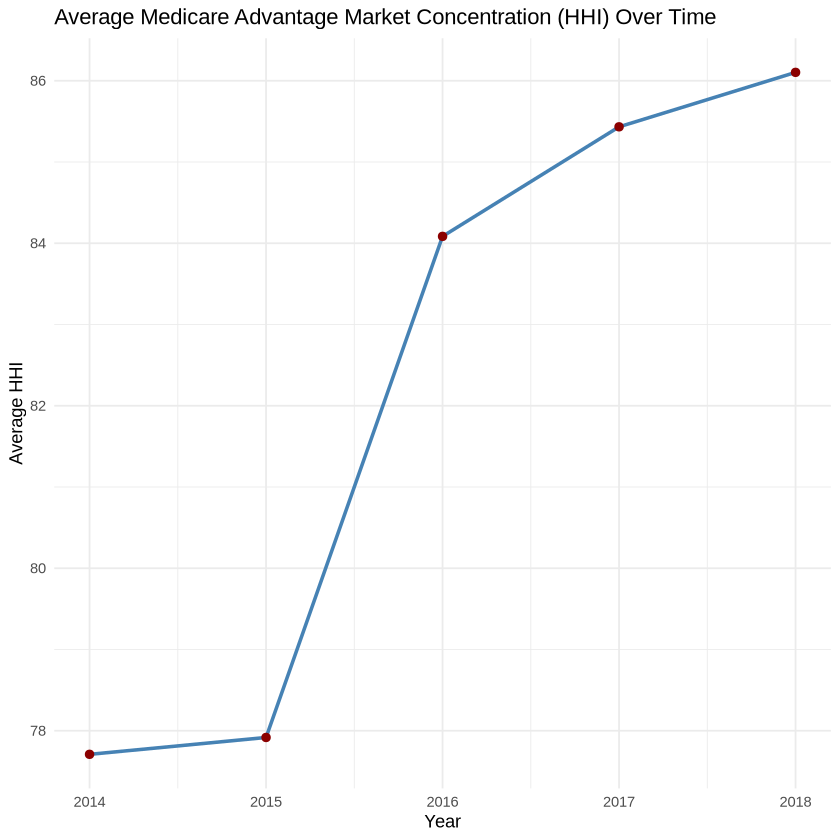

In [12]:
## Q3: Average Market Concentration (HHI) Over Time
library(dplyr)
library(ggplot2)

# Step 1: Filter the data (like Q1)
ma_filtered <- ma_all %>%
  filter(partd == "Yes", snp == "No") %>%
  filter(!is.na(enrollment) & enrollment > 0)  # remove rows with missing or zero enrollment

# Step 2: Compute HHI at the county-year level
ma_hhi <- ma_filtered %>%
  group_by(year, fips) %>%
  summarise(
    hhi = sum((enrollment / sum(enrollment))^2) * 10000,  # HHI formula
    .groups = "drop"
  )

# Step 3: Compute average HHI per year
avg_hhi <- ma_hhi %>%
  group_by(year) %>%
  summarise(mean_hhi = mean(hhi, na.rm = TRUE))

# Step 4: Plot average HHI over time
ggplot(avg_hhi, aes(x = year, y = mean_hhi)) +
  geom_line(color = "steelblue", size = 1) +
  geom_point(color = "darkred", size = 2) +
  labs(
    title = "Average Medicare Advantage Market Concentration (HHI) Over Time",
    x = "Year",
    y = "Average HHI"
  ) +
  theme_minimal()

In [7]:
##Q4
## Q4: Average Medicare Advantage Share Over Time
# Compute average share of MA per year
# If you don't have total Medicare eligibles, we'll just use enrollment sums per year as "share"
avg_ma <- ma_all %>%
  group_by(year) %>%
  summarise(
    total_enrollment = sum(enrollment, na.rm = TRUE),
    avg_share = mean(enrollment, na.rm = TRUE)  # if you only want average enrollment per plan/county
  )

# Plot average enrollment (or share) over time
ggplot(avg_ma, aes(x = year, y = total_enrollment)) +
  geom_line(color = "forestgreen", size = 1) +
  geom_point(color = "darkorange", size = 2) +
  labs(
    title = "Average Medicare Advantage Enrollment Over Time",
    x = "Year",
    y = "Total Enrollment"
  ) +
  theme_minimal()

ERROR: [1m[33mError[39m in `summarise()`:[22m
[1m[22m[36mℹ[39m In argument: `total_enrollment = sum(enrollment, na.rm = TRUE)`.
[36mℹ[39m In group 1: `year = 2014`.
[1mCaused by error:[22m
[33m![39m object 'enrollment' not found


In [8]:
##Estimate ATEs
# Assuming ma18 is already loaded and contains:
# contractid, planid, bid, ffs_cost (or avg_ffscost), HHI, enrollment, total_beneficiaries, etc.
ma18_clean <- ma18 %>%
  filter(year == 2018) %>%
  drop_na(bid, HHI, avg_ffscost)  # drop missing bids, HHI, or FFS costs


# Calculate HHI thresholds
hhi_quantiles <- quantile(ma18_clean$HHI, probs = c(0.33, 0.66), na.rm = TRUE)

# Define treatment variable
ma18_clean <- ma18_clean %>%
  mutate(
    competitive = case_when(
      HHI <= hhi_quantiles[1] ~ 1,   # competitive
      HHI >= hhi_quantiles[2] ~ 0,   # uncompetitive
      TRUE ~ NA_real_                 # middle group if needed
    )
  ) %>%
  drop_na(competitive)

table(ma18_clean$competitive)

ma18_clean %>%
  group_by(competitive) %>%
  summarise(avg_bid = mean(bid, na.rm = TRUE))

ERROR: [1m[33mError[39m in `drop_na()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `bid` doesn't exist.


In [ ]:
##Q6
#Split markets into FFS quartiles
ma18_clean <- ma18_clean %>%
  mutate(
    ffs_q1 = if_else(avg_ffscost <= quantile(avg_ffscost, 0.25), 1, 0),
    ffs_q2 = if_else(avg_ffscost > quantile(avg_ffscost, 0.25) & avg_ffscost <= quantile(avg_ffscost, 0.50), 1, 0),
    ffs_q3 = if_else(avg_ffscost > quantile(avg_ffscost, 0.50) & avg_ffscost <= quantile(avg_ffscost, 0.75), 1, 0),
    ffs_q4 = if_else(avg_ffscost > quantile(avg_ffscost, 0.75), 1, 0)
  )

#Average bid by treatment and quartile:
ma18_clean %>%
  group_by(competitive) %>%
  summarise(
    avg_bid_q1 = mean(bid[ffs_q1==1], na.rm = TRUE),
    avg_bid_q2 = mean(bid[ffs_q2==1], na.rm = TRUE),
    avg_bid_q3 = mean(bid[ffs_q3==1], na.rm = TRUE),
    avg_bid_q4 = mean(bid[ffs_q4==1], na.rm = TRUE)
  )

In [5]:
##Q7
# Create quartile factor
ma18_clean <- ma18_clean %>%
  mutate(ffs_quartile = ntile(avg_ffscost, 4))

# Matching using 1-to-1 nearest neighbor (Mahalanobis on FFS quartile)
m_nn <- matchit(competitive ~ ffs_quartile, data = ma18_clean,
                method = "nearest", distance = "mahalanobis", ratio = 1)

# Extract matched dataset
matched_data <- match.data(m_nn)

# Calculate ATE
ate_nn <- with(matched_data, mean(bid[competitive==1]) - mean(bid[competitive==0]))
ate_nn

#Part b
m_nn_var <- matchit(competitive ~ ffs_quartile, data = ma18_clean,
                    method = "nearest", distance = "inverse.variance", ratio = 1)

matched_data_var <- match.data(m_nn_var)
ate_nn_var <- with(matched_data_var, mean(bid[competitive==1]) - mean(bid[competitive==0]))
ate_nn_var

#Part c
# Fit propensity score model
ps_model <- glm(competitive ~ ffs_quartile, family = binomial(), data = ma18_clean)
ma18_clean$ps <- predict(ps_model, type = "response")

# Compute weights
ma18_clean <- ma18_clean %>%
  mutate(ipw = if_else(competitive==1, 1/ps, 1/(1-ps)))

# Weighted ATE
ate_ipw <- with(ma18_clean, sum(ipw * bid * competitive)/sum(ipw * competitive) -
                            sum(ipw * bid * (1-competitive))/sum(ipw * (1-competitive)))
ate_ipw

#Part d
lm_mod <- lm(bid ~ competitive * factor(ffs_quartile), data = ma18_clean)
summary(lm_mod)

# The coefficient on 'competitive' gives the ATE
coef(lm_mod)["competitive"]

ERROR: Error in eval(expr, envir, enclos): object 'ma18_clean' not found


In [ ]:
#Q8 - Interpretation

In [ ]:
#Q9: 
# NN matching with continuous covariates
m_cont <- matchit(competitive ~ avg_ffscost + total_beneficiaries, data = ma18_clean,
                  method = "nearest", ratio = 1)
matched_cont <- match.data(m_cont)
ate_cont <- with(matched_cont, mean(bid[competitive==1]) - mean(bid[competitive==0]))
ate_cont

# Regression using continuous covariates
lm_cont <- lm(bid ~ competitive + avg_ffscost + total_beneficiaries, data = ma18_clean)
coef(lm_cont)["competitive"]


In [ ]:
#Q10
# "Working with the Medicare Advantage data taught me the importance of careful filtering
# and understanding the structure of complex panel datasets. I learned how to define
# competitive markets using HHI percentiles. Working with the data was quite aggravating because the large datasets kept making the kernel quit"